In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [2]:
import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
from PyHEADTAIL.particles.particles import Particles
import PyHEADTAIL.particles.generators as generators

PyHEADTAIL v1.4.0-15-g54a769a0ea-dirty




In [3]:
# HELPERS
def plot_data(sigma_z, mean, Q, Qs):
    fig = plt.figure(figsize=(16, 16))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax1.plot(mean, '-', c='b')
    #ax1.plot(mean_y, '-', c='r')
    ax1.set_xlabel('turns')
    ax1.set_ylabel('mean [m]')

    ax2.plot(sigma_z, '-', c='b')
    ax2.set_xlabel('turns')
    ax2.set_ylabel('sigma_z [m]')

    fr_x, ax_x = my_fft(mean)
    markerline, stemlines, baseline = ax3.stem(fr_x, ax_x, label=r'bunch spectrum')
    plt.setp(baseline, 'color','b', 'linewidth', 2)
    ax3.axvline(Q%1, color='r', label='transverse main tune')
    ax3.axvline(Q%1 - Qs, color='g', linestyle='dashed', label=r'1st synchrotron sidebands')
    ax3.axvline(Q%1 + Qs, color='g', linestyle='dashed')
    handles, labels = ax3.get_legend_handles_labels()
    ax3.legend(handles, labels, loc='upper left')
    ax3.set_xlabel('tune')
    ax3.set_ylabel('amplitude')
    ax3.set_xlim((0.25, 0.32))

    plt.show()
    
def track_n_save(bunch, map_):
    mean_x = np.empty(n_turns)
    mean_y = np.empty(n_turns)
    sigma_z = np.empty(n_turns)
    
    for i in xrange(n_turns):
        mean_x[i] = bunch.mean_x()
        mean_y[i] = bunch.mean_y()
        sigma_z[i] = bunch.sigma_z()

        for m_ in map_:
            m_.track(bunch)

    return mean_x, mean_y, sigma_z

def copy_bunch(bunch_source, bunch_target):
    bunch_target.x = bunch_source.x.copy()
    bunch_target.xp = bunch_source.xp.copy()
    bunch_target.y = bunch_source.y.copy()
    bunch_target.yp = bunch_source.yp.copy()
    bunch_target.z = bunch_source.z.copy()
    bunch_target.dp = bunch_source.dp.copy()

def my_fft(data):
    t = np.arange(len(data))
    fft = np.fft.rfft(data)
    fft_freq = np.fft.rfftfreq(t.shape[-1])
    
    return fft_freq, np.abs(fft.real)

def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map):
    
    intensity = 1.05e11
    sigma_z = 0.059958
    gamma = 3730.26
    gamma_t = 1. / np.sqrt(alpha_0)
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = (linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs))

    epsn_x = 3.75e-6 # [m rad]
    epsn_y = 3.75e-6 # [m rad]
    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e) 
    
    bunch = generators.generate_Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma=gamma, mass=m_p, circumference=C,
        alpha_x=alpha_x, beta_x=beta_x, epsn_x=epsn_x,
        alpha_y=alpha_y, beta_y=beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z)
    
    return bunch

In [4]:
# Basic parameters.
n_turns = 500
n_segments = 5
n_macroparticles = 500

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_0 = [0.0003225]

**Things tested**
  - Instantiation of a TransverseMap (and therewith of several
    TransverseSegmentMaps as we have more than 1 segment).
  - With and without detuners, i.e. instantiation of Chromaticity and
    AmplitudeDetuning DetunerCollections as well as the corresponding
    SegmentDetuners.
  - Are betatron tunes Q_{x,y} and detuning strengths correctly
    scaled to segment lengths?
  - TransverseSegmentMap.track(beam) method.
      - Check spectrum of beam centroid motion.
      - Betatron tune (implicitly checks the scaling to segment lengths)
      - If chromaticity and linear synchro motion are on: synchrotron sidebands?
      - If amplitude detuning is on and there is initial kick: decoherence?
      - Does dispersion work correctly?
  - Is exception risen when s[0] != 0 or s[-1] != C?
  - Get optics at injection.

In [5]:
# TEST CASE SETUP
def gimme(D_x=None, D_y=None, *args, **kwargs):
    # Parameters for transverse map.
    s = np.arange(0, n_segments + 1) * C / n_segments

    alpha_x_inj = 0.
    alpha_y_inj = 0.
    beta_x_inj = 66.0064
    beta_y_inj = 71.5376
    
    alpha_x = alpha_x_inj * np.ones(n_segments)
    beta_x = beta_x_inj * np.ones(n_segments)
    if D_x is None:
        D_x = np.zeros(n_segments)

    alpha_y = alpha_y_inj * np.ones(n_segments)
    beta_y = beta_y_inj * np.ones(n_segments)
    if D_y is None:
        D_y = np.zeros(n_segments)
        
    if 'detuners' in kwargs:
        trans_map = TransverseMap(
            C, s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y, *kwargs['detuners'])
    else:
        trans_map = TransverseMap(
            C, s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)

    long_map = LinearMap(alpha_0, C, Q_s)
    bunch = generate_bunch(
        n_macroparticles, alpha_x_inj, alpha_y_inj, beta_x_inj, beta_y_inj,
        long_map)
    return bunch, trans_map, long_map

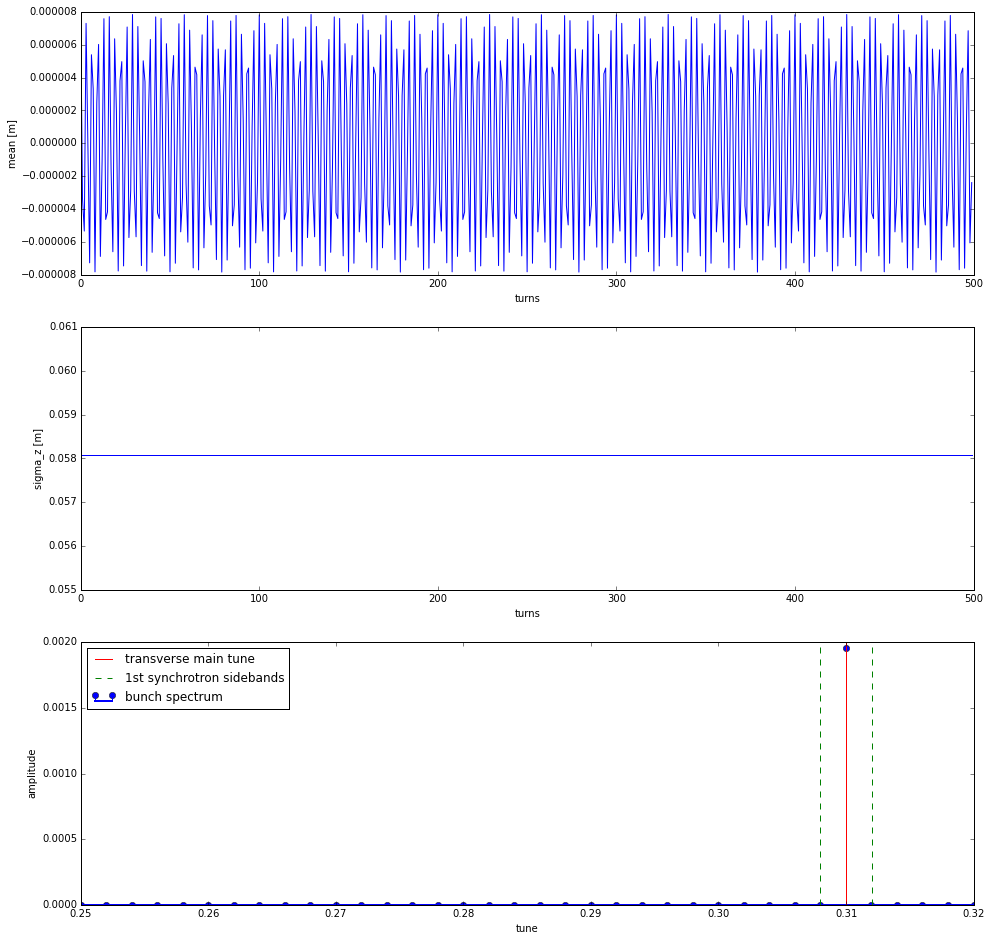

In [6]:
# CASE I
# Pure transverse tracking. Without detuners.
bunch, trans_map, _ = gimme()

map_ = trans_map
mean_x, mean_y, sigma_z = track_n_save(bunch, map_)
plot_data(sigma_z, mean_y, Q_y, Q_s)

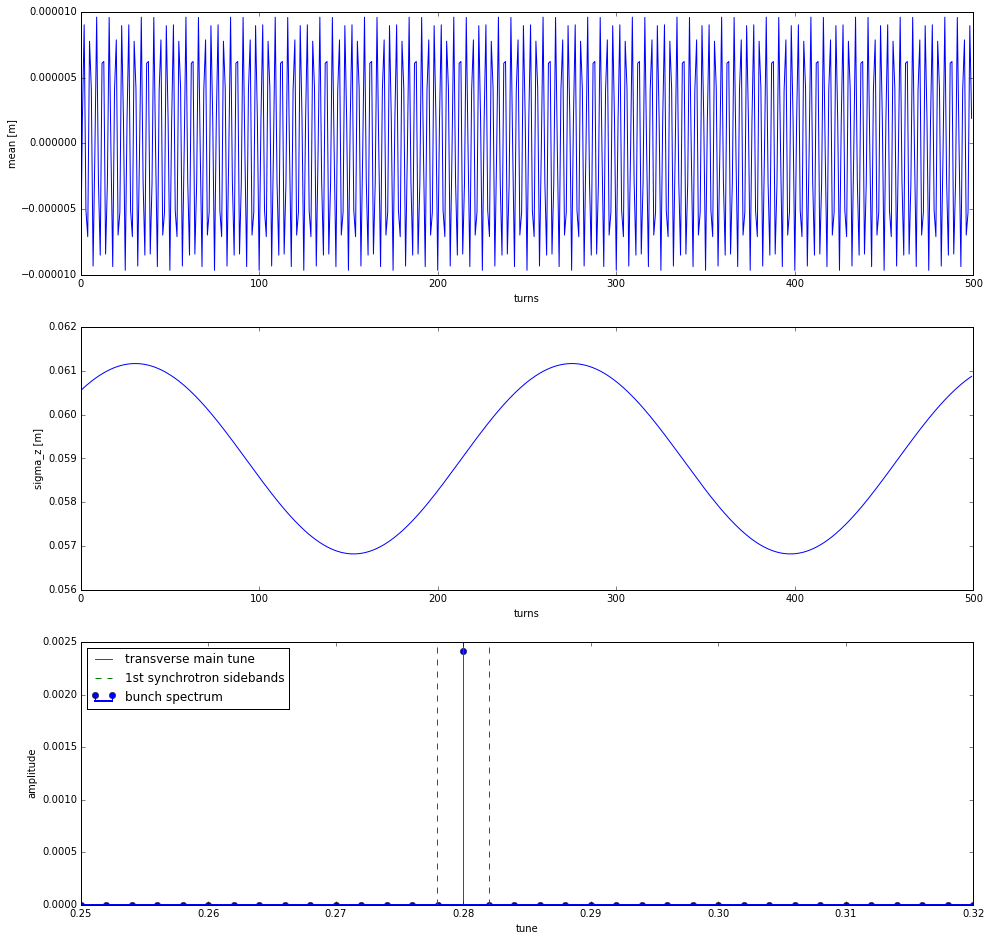

In [7]:
# CASE II
# Without detuners. With linear synchrotron motion.
bunch, trans_map, long_map = gimme()

# This tests if TransverseMap is actually a sequence.
trans_one_turn = [ m for m in trans_map ]

map_ = trans_one_turn + [long_map]
mean_x, mean_y, sigma_z = track_n_save(bunch, map_)
plot_data(sigma_z, mean_x, Q_x, Q_s)

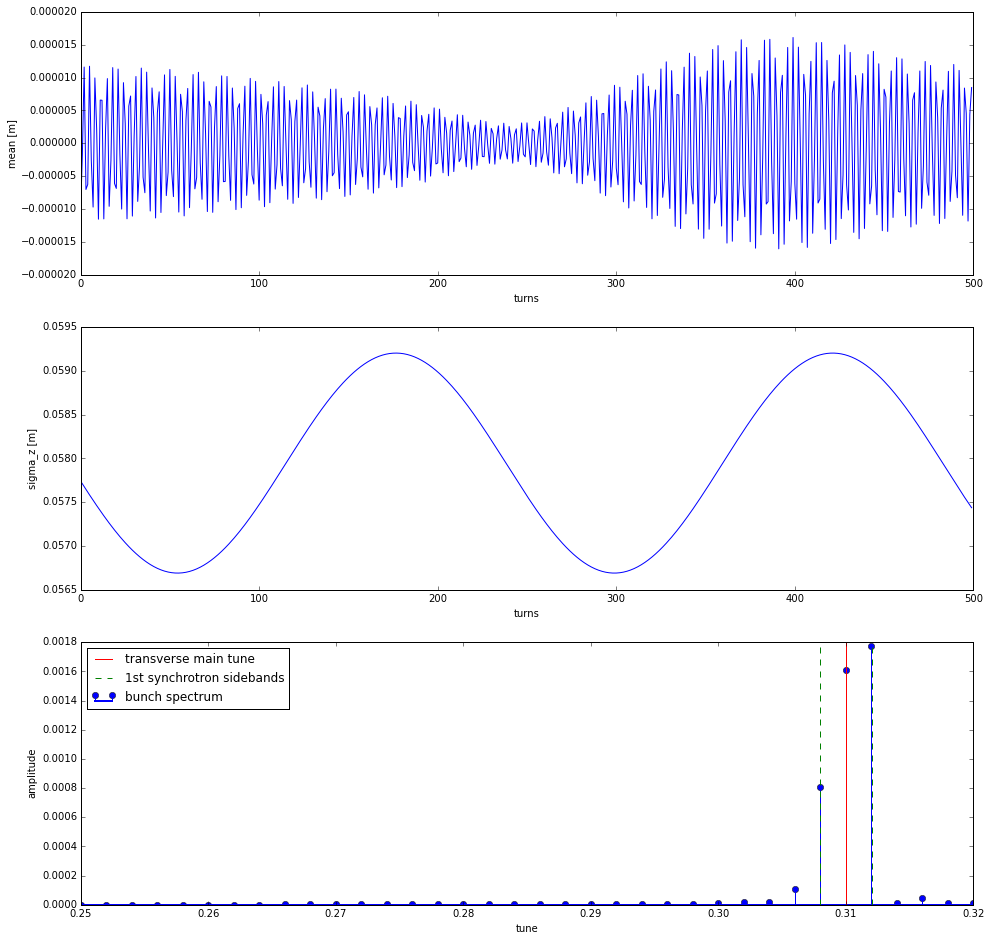

In [8]:
# CASE III
# With chromaticity in horizontal and vertical. With linear synchrotron motion.

chroma = Chromaticity(Qp_x=6, Qp_y=10)
bunch, trans_map, long_map = gimme(detuners=(chroma,))

trans_one_turn = [ m for m in trans_map ]

map_ = trans_one_turn + [long_map]
mean_x, mean_y, sigma_z = track_n_save(bunch, map_)
plot_data(sigma_z, mean_y, Q_y, Q_s)

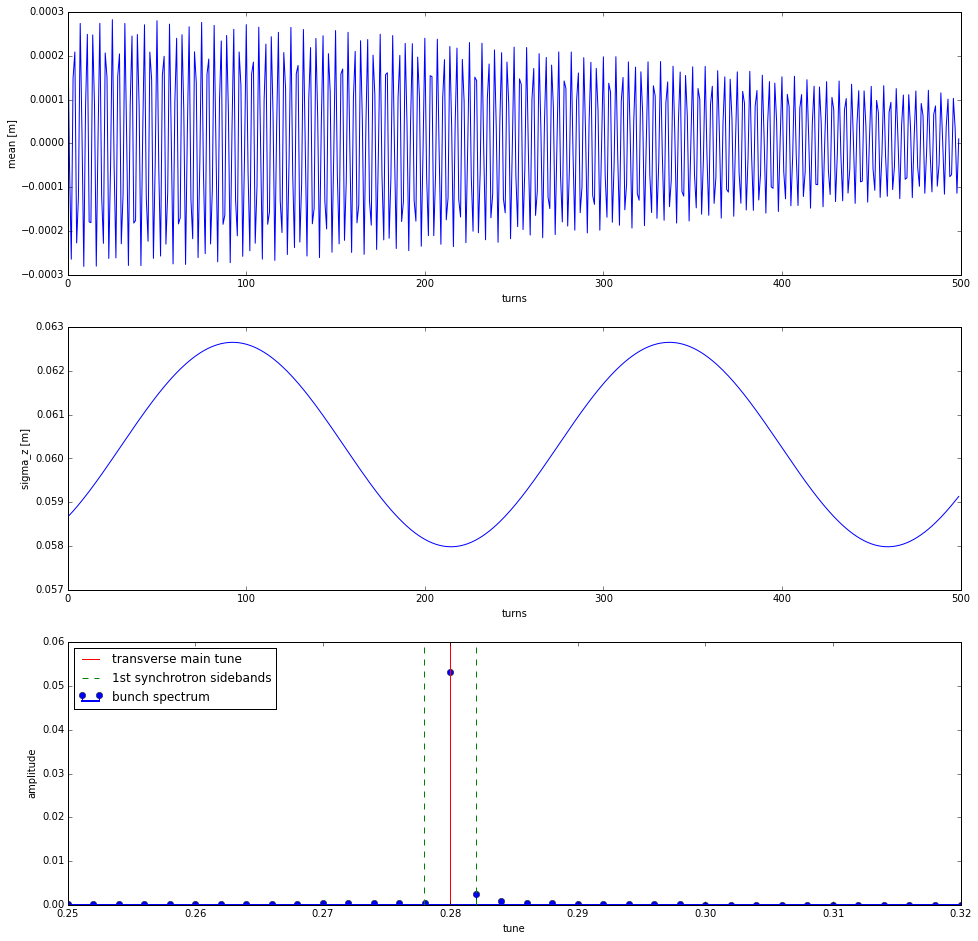

In [9]:
# CASE IV
# With amplitude detuning. With linear synchrotron motion. With initial kick.

ampl_det = AmplitudeDetuning.from_octupole_currents_LHC(i_focusing=200, i_defocusing=-200)
bunch, trans_map, long_map = gimme(detuners=(ampl_det,))

trans_one_turn = [ m for m in trans_map ]

map_ = trans_one_turn + [long_map]
bunch.x += 0.0003
bunch.y += 0.0005

mean_x, mean_y, sigma_z = track_n_save(bunch, map_)
plot_data(sigma_z, mean_x, Q_x, Q_s)

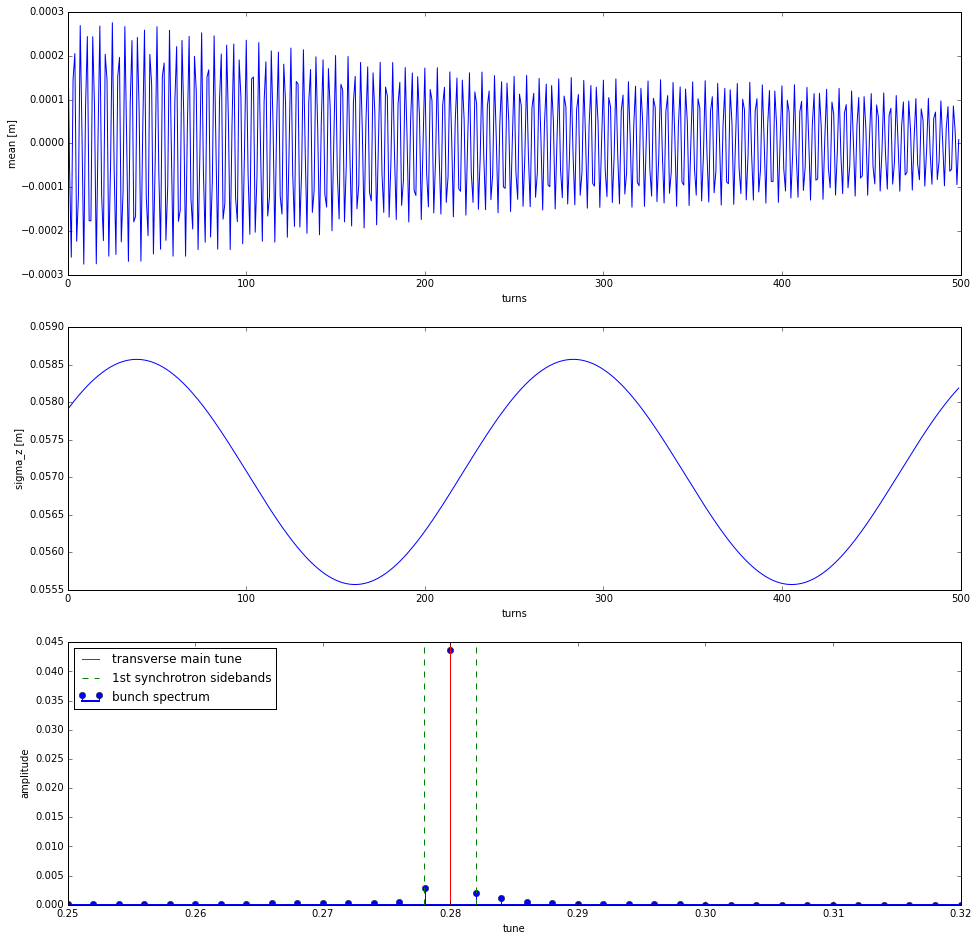

In [10]:
# CASE V
# With amplitude detuning and chromaticity. With linear synchrotron motion. With initial kick.

ampl_det = AmplitudeDetuning.from_octupole_currents_LHC(i_focusing=200, i_defocusing=-200)
chroma = Chromaticity(Qp_x=10, Qp_y=6)
bunch, trans_map, long_map = gimme(detuners=(ampl_det, chroma))

trans_one_turn = [ m for m in trans_map ]

map_ = trans_one_turn + [long_map]
bunch.x += 0.0003
bunch.y += 0.0005

mean_x, mean_y, sigma_z = track_n_save(bunch, map_)
plot_data(sigma_z, mean_x, Q_x, Q_s)

Non-zero dispersion; ensure the beam has been "blown-up" accordingly upon creation!


/usr/share/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/share/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


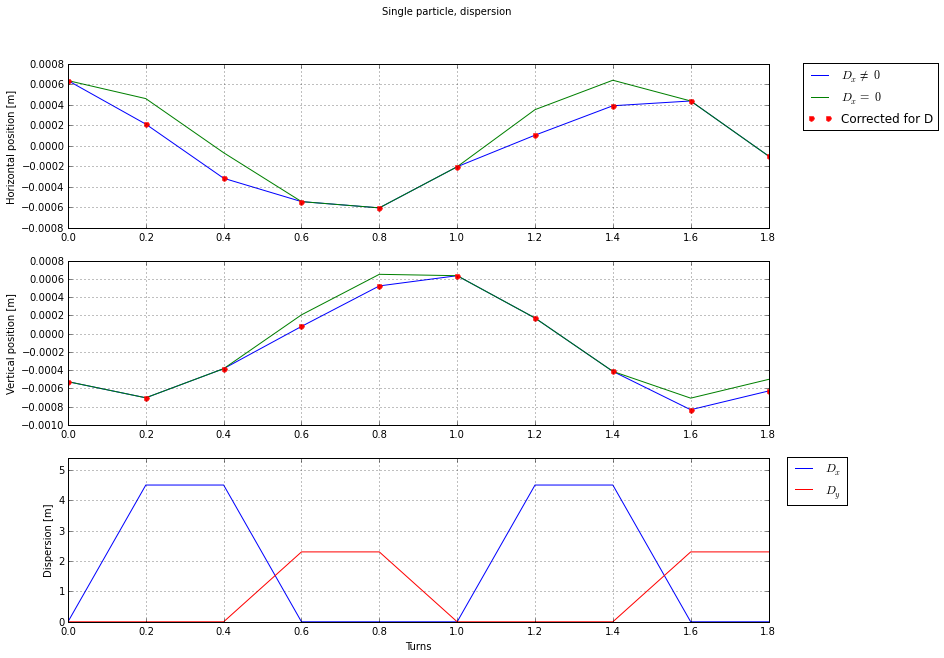

In [11]:
# CASE VI
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313, sharex=ax1)

fig.subplots_adjust(right=0.82)
fig.suptitle('Single particle, dispersion')

n_turns = 2
n_segments = 5

# Initial bunch distro to be used with and without dispersion
# for direct comparison.
bunch_orig, _, _ = gimme()

# With dispersion.
D_x = np.zeros(n_segments)
D_y = np.zeros(n_segments)
D_x[1] = 4.5
D_y[3] = 2.3
D_x[2] = 4.5
D_y[4] = 2.3

bunch_wD, trans_map_wD, _ = gimme(D_x, D_y)
copy_bunch(bunch_orig, bunch_wD)

# Add dispersion (manually for now).
bunch_wD.x += D_x[0] * bunch_wD.dp
bunch_wD.y += D_y[0] * bunch_wD.dp

x_i_wD = np.zeros((n_segments*n_turns, n_macroparticles))
y_i_wD = np.zeros((n_segments*n_turns, n_macroparticles))
for j in xrange(n_segments*n_turns):
    x_i_wD[j,:] = bunch_wD.x
    y_i_wD[j,:] = bunch_wD.y
    trans_map_wD[j%n_segments].track(bunch_wD)

# Without dispersion.
bunch_woD, trans_map_woD, _ = gimme()
copy_bunch(bunch_orig, bunch_woD)

x_i_woD = np.zeros((n_segments*n_turns, n_macroparticles))
y_i_woD = np.zeros((n_segments*n_turns, n_macroparticles))
dp_i_woD = np.zeros((n_segments*n_turns, n_macroparticles))
for j in xrange(n_segments*n_turns):
    x_i_woD[j,:] = bunch_woD.x
    y_i_woD[j,:] = bunch_woD.y
    dp_i_woD[j,:] = bunch_woD.dp
    trans_map_woD[j%n_segments].track(bunch_woD)

# Plot horizontal and vertical position of a single particle
# with and without dispersion.
kk = np.array(xrange(n_segments*n_turns))/float(n_segments)
wD1 = ax1.plot(kk, x_i_wD[:,0], 'b', label=r'$D_x \neq \, 0$')
woD1 = ax1.plot(kk, x_i_woD[:,0], 'g', label=r'$D_x = \, 0$')
wD2 = ax2.plot(kk, y_i_wD[:,0], 'b')
woD2 = ax2.plot(kk, y_i_woD[:,0], 'g')

for j in xrange(n_segments*n_turns):
    jj = float(j)/(n_segments)
    d_corr1, = ax1.plot(jj, x_i_woD[j,0] + dp_i_woD[j,0]*D_x[j%n_segments], '.r', ms=10)
    d_corr2, = ax2.plot(jj, y_i_woD[j,0] + dp_i_woD[j,0]*D_y[j%n_segments], '.r', ms=10)
d_corr1.set_label('Corrected for D')    

ax1.legend(bbox_to_anchor=(1.25, 1.04))
ax1.set_ylabel('Horizontal position [m]')
ax2.set_ylabel('Vertical position [m]')
ax1.grid('on')
ax2.grid('on')

# Plot dispersion functions.
kk = np.array(xrange(n_segments*n_turns))/float(n_segments)

ax3.plot(kk, np.tile(D_x, n_turns), 'b', label='$D_x$')
ax3.plot(kk, np.tile(D_y, n_turns), 'r', label='$D_y$')
ax3.grid('on')
ax3.set_ylabel('Dispersion [m]')
ax3.set_xlabel('Turns')
ax3.set_ylim(0., 1.2*max(np.amax(D_x), np.amax(D_y)))
ax3.legend(bbox_to_anchor=(1.12, 1.04))

plt.show()

In [12]:
# Test how detuning parameters and betatron tunes are scaled
# for the TransverseSegmentMaps.
Qp_x = 8.
Qp_y = 10.
chroma = Chromaticity(Qp_x, Qp_y)
bunch, trans_map, _ = gimme(detuners=(chroma,))

i = 1

print 'Q_x'
print Q_x / float(n_segments)
print trans_map[i].dQ_x

print 'Q_y'
print Q_y / float(n_segments)
print trans_map[i].dQ_y

# print 'Qp_x'
# print Qp_x / float(n_segments)
# print trans_map[i].segment_detuners[0].dQp_x

# print 'Qp_y'
# print Qp_y / float(n_segments)
# print trans_map[i].segment_detuners[0].dQp_y

app_x = 20.
app_y = 12.
app_xy = 30.
ampl_det = AmplitudeDetuning(app_x, app_y, app_xy)
bunch, trans_map, _ = gimme(detuners=(ampl_det,))

print 'app_x'
print app_x / float(n_segments)
print trans_map[i].segment_detuners[0].dapp_x

print 'app_y'
print app_y / float(n_segments)
print trans_map[i].segment_detuners[0].dapp_y

print 'app_xy'
print app_xy / float(n_segments)
print trans_map[i].segment_detuners[0].dapp_xy

Q_x
12.856
12.856
Q_y
11.862
11.862
app_x
4.0
4.0
app_y
2.4
2.4
app_xy
6.0
6.0


In [13]:
# Test if optics at injection are correctly returned.
s = np.arange(0, n_segments + 1) * C / n_segments
alpha_x_inj = 0.
alpha_y_inj = 0.
beta_x_inj = 66.0064
beta_y_inj = 71.5376

alpha_x = alpha_x_inj * np.ones(n_segments)
beta_x = beta_x_inj * np.ones(n_segments)
alpha_y = alpha_y_inj * np.ones(n_segments)
beta_y = beta_y_inj * np.ones(n_segments)

trans_map = TransverseMap(
    C, s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
alpha_x_inj, beta_x_inj, alpha_y_inj, beta_y_inj = trans_map.get_injection_optics()
print alpha_x_inj, beta_x_inj, alpha_y_inj, beta_y_inj

Non-zero dispersion; ensure the beam has been "blown-up" accordingly upon creation!
0.0 66.0064 0.0 71.5376


In [14]:
# Test if exception is risen when s[0] != 0 or s[-1] != C
s = np.array([0., 4, 10, 12, C-1])

try:
    trans_map = TransverseMap(
        C, s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y)
    print ('test NOT passed. No error raised!')
except ValueError as exc:
    print ('test passed.\n')
    print ('Error message:\n' + exc.message)

test passed.

Error message:
The first element of s must be zero 
and the last element must be equal to the 
accelerator circumference C. 

